### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

In [92]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

# Data preparation

In [93]:
class DataProperties:
    n_samples = 500 # 200
    labeled_percentage = 0.03
    n_dims = 2
    n_clusters = 2

    unlabeled = -1000000  # To mark the unlabelled data instance

In [94]:
from sklearn.datasets import make_blobs
import numpy as np

# Plotting
import matplotlib.pyplot as plt

np.random.seed(numpy_seed)

In [95]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')

Data shape: X: (500, 2), Y: (500,)


## Visualize fully labeled data

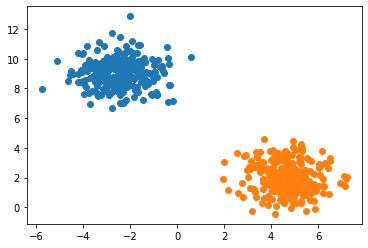

In [96]:
def plot_clusters(Y):
    fig, ax = plt.subplots()

    clusters = np.unique(Y)
    for c in clusters:
        mask = Y == c
        subset = X[mask]
        ax.scatter(
            subset[:, 0],
            subset[:, 1], 
            marker = 'o'
        )


plot_clusters(Y)

## Unlabel subset and visualize

In [97]:
def delabel_data (labeled_data, labeled_percent, delabel_value):
    res = np.ndarray.copy(labeled_data)
    clusters_ids = np.unique(labeled_data)

    for cluster_id in clusters_ids:
        # find indices of object, labeled as cluster_id
        # we keep 'labeled_percent' points still labeled

        cluster_indices = np.where(labeled_data == cluster_id)[0]
        print(f'Found {len(cluster_indices)} instances of object {cluster_id}')

        n_to_delabel = int(len(cluster_indices) * (1 - labeled_percent))
        print(f'We have to delabel {n_to_delabel} instances')

        # we choose data to delabel randomly
        indices_to_delabel = np.random.choice(
            len(cluster_indices - 1),
            n_to_delabel,
            replace = False
        )

        assert len(indices_to_delabel) == n_to_delabel, print(len(indices_to_delabel))
        assert np.max(indices_to_delabel) < len(res)
        assert np.max(indices_to_delabel) <= np.max(cluster_indices)

        res[
            cluster_indices[indices_to_delabel]
        ] = delabel_value
    return res

In [98]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

assert(
    len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]) == int(len(Y) * (1 - DataProperties.labeled_percentage))
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

Found 250 instances of object 0.0
We have to delabel 242 instances
Found 250 instances of object 1.0
We have to delabel 242 instances


AssertionError: 

## Visualize data after delabelling

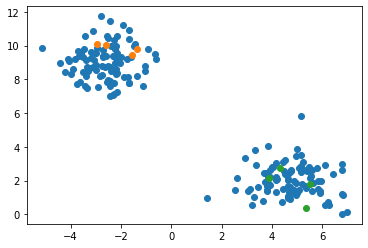

In [ ]:
plot_clusters(Y_delabeled)

# Gradient Descent method

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [ ]:
import collections
collections.Counter(Y_delabeled)

Counter({-1000000.0: 192, 1.0: 4, 0.0: 4})

In [ ]:
def euclidian_similarity(X_i, X_j):
    return np.linalg.norm(X_i - X_j)  # sqrt( sum((x_ii - x_ji)^2) )

class GradientSolver:
    def __init__(
        self, 
        lr_strategy, 
        learning_rate, 
        similarity_func, 
        bcgd_strategy = None
    ):

        available_lr_strategies = [
            'lr_constant'
        ]
        assert lr_strategy in available_lr_strategies, print(f'Pick available lr_strategy: {available_lr_strategies}')

        self.lr_strategy = lr_strategy
        self.learning_rate = learning_rate
        self.similarity_func = similarity_func

        self.losses = []


    def get_learning_rate(self):
        if self.lr_strategy == 'lr_constant':
            return self.learning_rate   

    def compute_grad_component(self, X, Y, labeled_idxs, unlabeled_idxs, idx):

        grad_component = 0.0
            
        for labeled_idx in labeled_idxs:
            w_ij = np.linalg.norm(X[idx] - X[labeled_idx])
            grad_component += 2 * w_ij * (Y[idx] - Y[labeled_idx])

        for another_unlab_idx in unlabeled_idxs:
            w_ij_ = np.linalg.norm(X[idx] - X[another_unlab_idx])
            grad_component += 2 * w_ij_ * (Y[idx] - Y[another_unlab_idx])

        return grad_component

            
    def compute_grad(self, X, Y, labeled_idxs, unlabeled_idxs):

        grad = []
        for unlabeled_idx in unlabeled_idxs:
            # compute component of gradient for this 
            # current unlabeled
            grad_component = self.compute_grad_component(X, Y, labeled_idxs, unlabeled_idxs, idx=unlabeled_idx)
            grad.append(grad_component)

        return np.array(grad)

    def compute_loss(self, X, Y, labeled_idxs, unlabeled_idxs):
        res = 0
        for labeled_idx in labeled_idxs:
            for unlab_idx in unlabeled_idxs:
                w_ij = np.linalg.norm(X[labeled_idx] - X[unlab_idx])
                res += w_ij * ((Y[labeled_idx] - Y[unlab_idx]) ** 2)
        
        for unlab_idx in unlabeled_idxs:
            for another_unlab_idx in unlabeled_idxs:
                w_ij = np.linalg.norm(X[unlab_idx] - X[another_unlab_idx])
                res += 0.5 * w_ij * ((Y[unlab_idx] - Y[another_unlab_idx]) ** 2)
        
        return res
    
    def threshold_proc(self, Y_preds):
        Y_preds[Y_preds > 0.5] = 1.0
        Y_preds[Y_preds <= 0.5] = 0.0
        return Y_preds
        

In [ ]:
class GradientDescentSolver(GradientSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def solve(self, X, Y, iters_limit, delta_loss_limit):

        labeled_idxs = np.where(Y != DataProperties.unlabeled)[0]
        unlabeled_idxs = np.where(Y == DataProperties.unlabeled)[0]

        Y_res = np.ndarray.copy(Y)
        
        # fix initial approximation
        Y_res[Y_res == DataProperties.unlabeled] = 0.5

        loss_prev = 0.0
        self.losses = []
        for i in range(iters_limit):
            loss = self.compute_loss(X, Y_res, labeled_idxs, unlabeled_idxs)
            self.losses.append(loss)
            delta_loss = abs(loss - loss_prev)
            print(f'Loss: {loss}, delta loss: {delta_loss}')


            if (i > 0 and delta_loss < delta_loss_limit):
                break
            else:
                grad = self.compute_grad(X, Y_res, labeled_idxs, unlabeled_idxs)

                learning_rate = self.get_learning_rate()
                updates = -learning_rate * grad
  
                # print(f'Max update: {np.max(updates)}')

                assert len(unlabeled_idxs) == len(grad)
                for i in range(len(grad)):
                    Y_res[unlabeled_idxs[i]] += updates[i]
                
                loss_prev = loss

        
        return self.threshold_proc(Y_res)
        

In [ ]:
solver = GradientDescentSolver(
    similarity_func = euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.00014
)

In [99]:
Y_preds_GD = solver.solve(
    X,
    Y_delabeled,
    iters_limit = 50,
    delta_loss_limit = 0.0005
)

Loss: 11160.784681970688, delta loss: 11160.784681970688
Loss: 11072.668386779598, delta loss: 88.1162951910901
Loss: 11056.957499427606, delta loss: 15.710887351991914
Loss: 11054.012571022335, delta loss: 2.9449284052716393
Loss: 11053.456733750683, delta loss: 0.5558372716513986
Loss: 11053.349860548487, delta loss: 0.10687320219585672
Loss: 11053.327505920945, delta loss: 0.022354627542881644
Loss: 11053.321156482198, delta loss: 0.006349438746838132
Loss: 11053.317925591464, delta loss: 0.0032308907339029247
Loss: 11053.315384857975, delta loss: 0.002540733488785918
Loss: 11053.313072421428, delta loss: 0.0023124365470721386
Loss: 11053.310896423533, delta loss: 0.0021759978953923564


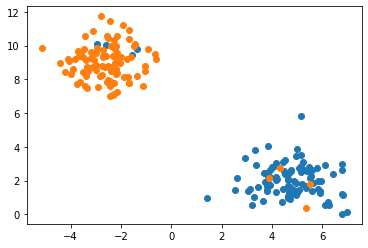

In [ ]:
plot_clusters(Y_preds_GD)

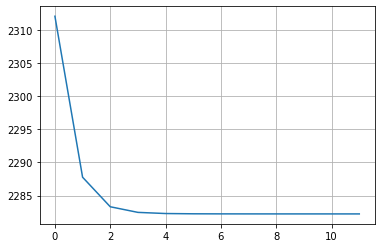

In [ ]:
plt.plot(solver.losses)
plt.grid()

# Block coordinates gradient descent (randomized)

In [ ]:
class BCGDSolver(GradientSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        available_strategies = [
            # 'cyclic_order',
            'random permutation',
            # 'random sampling'
        ]

        block_strategy = kwargs['bcgd_strategy']
        assert block_strategy in available_strategies, \
            print(f'Please choose available block strategy: {available_strategies}')
        
        self.block_strategy = block_strategy
        # strategies - random permutation & random sampling

    def pick_block_indices(self, unlabeled_indices):
        
        if self.block_strategy == 'random permutation':
            # we just permute the dimensions
            return np.random.permutation(unlabeled_indices)


    def solve(self, X, Y, iter_limit, delta_loss_limit):

        Y_res = np.ndarray.copy(Y)
        labeled_indices = np.where(Y_res != DataProperties.unlabeled)[0]
        unlabeled_indices = np.where(Y_res == DataProperties.unlabeled)[0]
        assert len(labeled_indices) + len(unlabeled_indices) == len(Y_res)

        # Step 1. Choose initial point
        Y_res[unlabeled_indices] = 0.5

        loss_prev = 0
        self.losses = []
        for i in range(iter_limit):

            loss = self.compute_loss(X, Y_res, labeled_indices, unlabeled_indices)
            self.losses.append(loss)
            delta_loss = abs(loss - loss_prev)
            loss_prev = loss
            print(f'LOSS: {loss}, Delta: {delta_loss}')

            # Specific condition
            if (i > 0) and delta_loss <= delta_loss_limit:
                break
            else:
                y = np.ndarray.copy(Y_res)  # y_0
                del Y_res

                # depending on the strategy,
                # S contains one random block, permutation
                # of available coordinates, or same sequence of
                # coordinates (for cyclic approach)
                S = self.pick_block_indices(unlabeled_indices)  # Pick random permutation of unlabeled indices
                
                # l = len(S)
                # And now we move across S and update y variable
                for index in S:
                    assert(index in unlabeled_indices)
                    learning_rate = self.get_learning_rate()
                    
                    grad_component = self.compute_grad_component(
                        X,
                        y,
                        labeled_indices,
                        unlabeled_indices,
                        idx = index
                    )
                    grad_vector = np.zeros(y.shape[0])
                    grad_vector[index] = grad_component
                    y = y - learning_rate * grad_vector
                
                Y_res = y
                del y
        return self.threshold_proc(Y_res)

In [ ]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.0001,
    similarity_func = euclidian_similarity,

    bcgd_strategy = 'random permutation',
)

In [ ]:
Y_preds_BCGD_permutation = random_solver.solve(
    X,
    Y_delabeled,
    iter_limit = 50,
    delta_loss_limit = 0.005
)

LOSS: 2312.110668607197, Delta: 2312.110668607197
LOSS: 2293.9012525752755, Delta: 18.20941603192159
LOSS: 2286.8226330484135, Delta: 7.078619526861985
LOSS: 2284.053493996459, Delta: 2.7691390519544257
LOSS: 2282.96152505198, Delta: 1.0919689444790492
LOSS: 2282.5257172814568, Delta: 0.4358077705232972
LOSS: 2282.3491754121565, Delta: 0.17654186930030846
LOSS: 2282.2762091045647, Delta: 0.0729663075917415
LOSS: 2282.245246094686, Delta: 0.030963009878632874
LOSS: 2282.231651893079, Delta: 0.013594201607247669
LOSS: 2282.2254143065593, Delta: 0.006237586519546312
LOSS: 2282.2223821856273, Delta: 0.003032120931948157


In [89]:
plot_clusters(Y_preds_BCGD_permutation)

NameError: name 'Y_preds_BCGD_permutation' is not defined

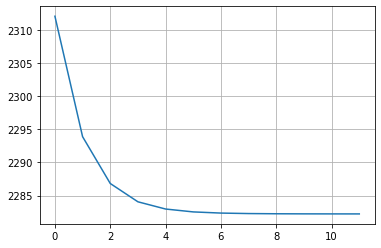

In [91]:
plt.plot(random_solver.losses)
plt.grid()